<h1><center>Fashion MNIST</center></h1>

<b>Fashion-MNIST</b> is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, for a total of 784 pixels in total, associated with a label from 10 classes. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels, and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed $x$ as $x = i * 28 + j$, where $i$ and $j$ are integers between 0 and 27. The pixel is located on row $i$ and column $j$ of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.


<b>Labels</b>
Each training and test example is assigned to one of the following labels:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot


TL;DR

* Each row is a separate image
* Column 1 is the class label.
* Remaining columns are pixel numbers (784 total).
* Each value is the darkness of the pixel (1 to 255)

The dataset is taken from https://www.kaggle.com/zalando-research/fashionmnist. Please go to the website for a complete description of the dataset.

Some of the codes and notes in this notebook is taken from <b>Hands-on Machine Learning with Scikit-Learn, Keras \& TensorFlow</b>, *2nd Edition by Aurelien Geron*.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

<h2>Reading the Training Data</h2>

In [2]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_train.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# check the data types of df_train. Note that all of the features is in integer form

df_train.dtypes

label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

In [4]:
x_train = df_train.loc[:, df_train.columns != 'label'].values
print(x_train.shape)

(60000, 784)


In [5]:
y_train = df_train["label"]
y_train.shape

(60000,)

<h2>Explore the data</h2>

Let us check few images from the dataset.

In [6]:
def plot_img(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Here are the corresponding class names:

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Pullover , label:  2


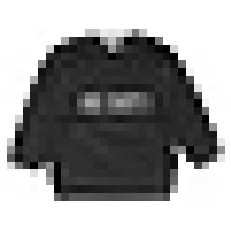

In [8]:
plot_img(x_train[0])
print(class_names[y_train[0]], ", label: ", y_train[0])

Ankle boot , label:  9


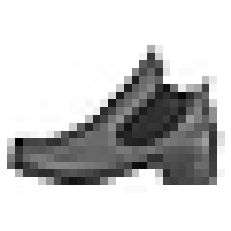

In [9]:
plot_img(x_train[1])
print(class_names[y_train[1]], ", label: ", y_train[1])

Now let us check first 50 images from the dataset.

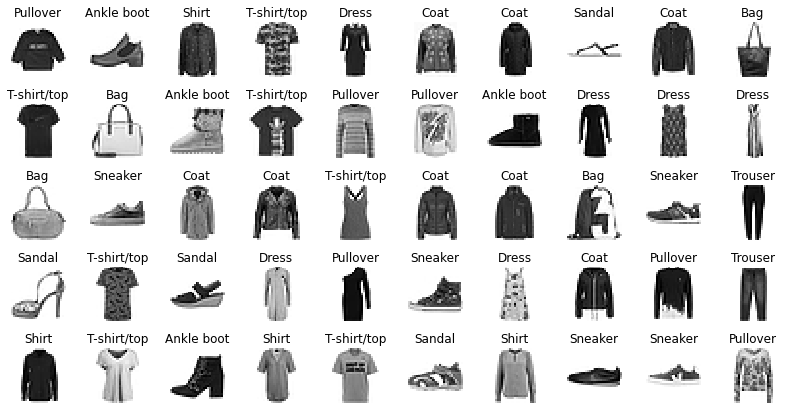

In [10]:
n_rows = 5
n_cols = 10
index = 0
plt.figure(figsize=(n_cols * 1.4, n_rows * 1.4))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index].reshape(28, 28), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

<h2>Reading the Testing Data</h2>

In [11]:
df_test = pd.read_csv("fashion-mnist_test.csv")
df_test.shape

(10000, 785)

In [12]:
# check the data types of df_test. Note that all of the features is in integer form

df_test.dtypes

label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

In [13]:
x_test = df_test.loc[:, df_test.columns != 'label'].values
print(x_test.shape)

(10000, 784)


In [14]:
y_test = df_test["label"]
y_test.shape

(10000,)

<h2>Multiclass Classification</h2>

In [15]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [16]:
# Will use this later to evaluate the cross-validation

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [17]:
# Standardize the training and testing dataset and change the x_train and x_test to float

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.astype(np.float64))
x_test = scaler.fit_transform(x_test.astype(np.float64))
x_train[0:5]

array([[-0.00950488, -0.02269303, -0.02890692, ..., -0.15825831,
        -0.09143181, -0.03304557],
       [-0.00950488, -0.02269303, -0.02890692, ..., -0.15825831,
        -0.09143181, -0.03304557],
       [-0.00950488, -0.02269303, -0.02890692, ..., -0.15825831,
        -0.09143181, -0.03304557],
       [-0.00950488, -0.02269303, -0.02890692, ..., -0.15825831,
        -0.09143181, -0.03304557],
       [-0.00950488, -0.02269303, -0.02890692, ..., -0.15825831,
        -0.09143181, -0.03304557]])

In [18]:
print('x_train:', x_train.dtype)
print('x_test:', x_test.dtype)

x_train: float64
x_test: float64


Since the *x_train* from the original *df_train* dataset contains 60,000 rows and 784 features, training the models will be computational costly and take a lot of time for a regular home computer. Therefore, we will set aside 12,500 rows which is chosen randomly from *df_train* to create *df_new* and use it to perform <b>GridSearchCV</b>.

In [19]:
# Select 12500 rows of data from df_train to create df_new

df_new = df_train.sample(n = 12500, random_state = 0)
df_new = df_new.reset_index(drop = True)
df_new.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,208,174,128,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,1,0,1,...,49,40,3,0,40,66,11,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,128,126,126,120,129,75,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,123,145,152,206,58,0,0,0,0,0


In [20]:
# Create x_new and y_new from df_new

x_new = df_new.loc[:, df_new.columns != 'label'].values
y_new = df_new["label"]
print(x_new.shape)
print(y_new.shape)

(12500, 784)
(12500,)


In [21]:
# Standardize the x_new dataset

x_new = StandardScaler().fit(x_new).transform(x_new)

# Create test set (validation set) and train set from x_new and y_new

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split( x_new, y_new, test_size=0.2, random_state=0)
print ('Train set:', x_train_new.shape,  y_train_new.shape)
print ('Test set:', x_test_new.shape,  y_test_new.shape)

Train set: (10000, 784) (10000,)
Test set: (2500, 784) (2500,)


<h3>Model 1: Support Vector Machine (SVM)</h3>

Let us try to find the best combination of hyperparameter values for the SVM by performing Grid Search.

In [20]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

The code below is commented since it can take more than an hour for a regular home computer.

In [31]:
# instantiate the grid. Note that the default parameter of GridSearchCV is
# cv=5 and scorring = sklearn.metrics.accuracy_score for classification 

#grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

# fit the grid with data
#grid_svm.fit(x_train_new,y_train_new)

#get the best estimator
#grid_svm.best_estimator_

If we run the above code, we will see the result of the grid search is *SVC(C=10, gamma=0.001)*, i.e., the best performer is the default kernel, which is *"rbf"* with *C=10* and *gamma=0.001*.

In [21]:
# Let us fit the model using the result of the grid search on a x_train_new and y_train_new
# and see the result

svm_clf = SVC(C=10, gamma=0.001)
svm_clf.fit(x_train_new, y_train_new)

SVC(C=10, gamma=0.001)

Under the hood, Scikit-Learn actually used the OvO (One-Versus-One) strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that with the highest score.

In [22]:
# Check the classes of svm_clf

svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Let’s use the *cross_val_score()* function to evaluate our SVM model, using K-fold cross-validation with three folds. Note that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [23]:
# Now let's see the accuracy score of x_train_new and y_train_new

accuracy_svm = cross_val_score(svm_clf, x_train_new, y_train_new, cv=3, scoring="accuracy")
display_scores(accuracy_svm)

Scores: [0.87282543 0.85718572 0.85388539]
Mean: 0.861298847341243
Standard deviation: 0.008261142389485348


The accuracy is from the *x_train_new* and *y_train_new* is above 85% accross all folds which is not bad. Now let us see the accuracy from the *x_train (60000 x 784)* and *y_train (60000, )* (the *x* and *y* derive from the original training dataset)

In [24]:
# fit the model on x_train and y_train

svm_clf.fit(x_train, y_train)

SVC(C=10, gamma=0.001)

In [25]:
# let's see the accuracy score of x_train and y_train

accuracy_svm2 = cross_val_score(svm_clf, x_train, y_train, cv=3, scoring="accuracy")
display_scores(accuracy_svm2)

Scores: [0.90025 0.90025 0.8976 ]
Mean: 0.8993666666666668
Standard deviation: 0.0012492219800962535


The accuracy of the cross validation score gets almost over 90% on all test fold which is very good. Moreover, the standard deviation of the score is low which is also good.

In [26]:
y_hat_svm = svm_clf.predict(x_test)

Note that if we want to force Scikit-Learn to use <b>one-versus-one</b> or <b>one-versus-the-rest</b>, we
can use the *OneVsOneClassifier* or *OneVsRestClassifier* classes. Simply create an
instance and pass a classifier to its constructor (it does not even have to be a binary
classifier). For example, this code creates a multiclass classifier using the <b>OvR</b> strategy,
based on an SVC:

> ovr_clf = OneVsRestClassifier(SVC())
<br>> ovr_clf.fit(x_train, y_train)

<h4>Support Vector Machine Evaluation</h4>

In [27]:
print("Test set Accuracy: ", accuracy_score(y_test, y_hat_svm))

Test set Accuracy:  0.9068


The accuracy of the test set is almost 91% which is very good.

In [28]:
print (classification_report(y_test, y_hat_svm))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.83      0.84      1000
           3       0.91      0.92      0.91      1000
           4       0.85      0.88      0.86      1000
           5       0.98      0.95      0.97      1000
           6       0.79      0.72      0.75      1000
           7       0.94      0.96      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



We see that the classification report shows that the precision and recall value is very high for class 1, 5, 7, 8, 9 since they are all above 0.91. It is high for class 0, 2, 3, 4 since they are between 0.83 and 0.90. And moderate for class 6 since it is between 0.72 and 0.76. 

<h3>Model 2: Random Forest Classifier</h3>

In [19]:
from sklearn.ensemble import RandomForestClassifier

# create random forest classifier model

rfc_clf = RandomForestClassifier(random_state=0)

# Print the default hyperparemeters

print(rfc_clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


Since this analysis is done using a regular home computer which will take a long time if we perform randomize search and grid search, we will just use the default hyperameters.

In [22]:
# Let's just use the default hyperparameters on x_train and y_train this time

# Fit the random search model
rfc_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In this case, the classifier correctly predict the first data set. Let's see how the model generalize.

In [23]:
accuracy_frt = cross_val_score(rfc_clf, x_train, y_train, cv=3, scoring="accuracy")
display_scores(accuracy_frt)

Scores: [0.87875 0.8808  0.87765]
Mean: 0.8790666666666667
Standard deviation: 0.0013053309499467462


The accuracy of the cross validation score gets almost over 87% on all test fold which is very good. Moreover, the standard deviation of the score is low which is also good.

<h4>Random Forest Classifier Evaluation</h4>

In [24]:
y_hat_frt = rfc_clf.predict(x_test)
print("Test set Accuracy: ", accuracy_score(y_test, y_hat_frt))

Test set Accuracy:  0.8815


The accuracy of the test set of Random Forest classifier is 88% which is very good.

In [25]:
print (classification_report(y_test, y_hat_frt))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.88      0.93      0.90      1000
           4       0.80      0.86      0.83      1000
           5       0.97      0.94      0.96      1000
           6       0.74      0.61      0.67      1000
           7       0.92      0.93      0.92      1000
           8       0.96      0.97      0.97      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Here the classification report shows that the precision and recall value is very high for class 1, 5, 7, 8, 9 since they are all above 0.92. It is high for class 0, 2, 3, 4 since they are between 0.80 and 0.93. And moderate for class 6 since it is between 0.61 and 0.74. 

<h3>Model 3: Artificial Neural Network with Keras</h3>

In [22]:
import tensorflow as tf
from tensorflow import keras

Since keras can perform calculation pretty fast, let us just use all the data from *x_train* and *y_train*, i.e., the full training set. However, let's split the *x_train* and *y_train* into a validation set and a (smaller) training set

In [23]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split( x_train, y_train, test_size=0.1, random_state=0)
print ('Train set:', x_train2.shape,  y_train2.shape)
print ('Validation set:', x_valid2.shape,  y_valid2.shape)

Train set: (54000, 784) (54000,)
Validation set: (6000, 784) (6000,)


Let us create a *Sequential model* classification MLP (Multi-layer Perceptron) with two hidden layers:

In [103]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(784,)),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch
it by name:

In [104]:
model.layers

The model’s *summary()* method displays all the model’s layers, including each layer’s name (which is automatically generated unless we set it when creating the layer).

In [105]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 200)               157000    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden
layer has 784 × 200 connection weights, plus 200 bias terms, which adds up to
157,000 parameters! This gives the model quite a lot of flexibility to fit the training
data, but it also means that the model runs the risk of overfitting, especially when you
do not have a lot of training data.

For understating a Keras Model, it always good to have visual representation of model layers. Let's display Keras Model architecture and save to a file.

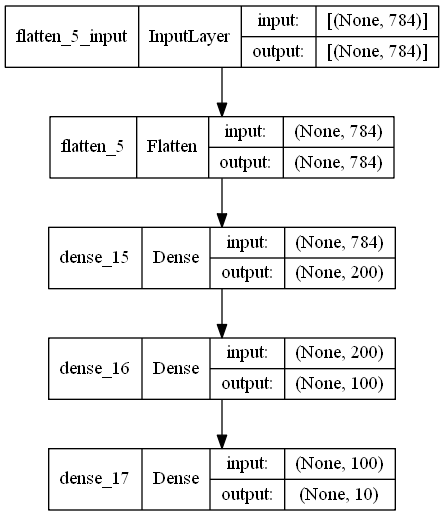

In [106]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [107]:
# Let's try to fetch a layer by its index. In this case we want to get the name of layers[1]

model.layers[1].name

'dense_15'

In [108]:
# Find the weights of layers[1]

weights, biases = model.layers[1].get_weights()
weights

array([[-0.03045566, -0.07228886, -0.00834741, ..., -0.00432251,
         0.05720702, -0.05117636],
       [ 0.0196639 ,  0.04167528,  0.00021894, ..., -0.065672  ,
         0.05102506, -0.01372778],
       [ 0.06002927,  0.00916407, -0.03467432, ..., -0.01817384,
        -0.00636565, -0.00770811],
       ...,
       [-0.06796648, -0.0576353 , -0.05054778, ...,  0.0386845 ,
        -0.02394938,  0.07053857],
       [-0.02126317, -0.03978262, -0.06674273, ..., -0.0660947 ,
         0.06946254,  0.04716665],
       [ 0.01012848, -0.00881162, -0.04722521, ...,  0.04220495,
         0.05676332, -0.05713803]], dtype=float32)

In [109]:
# Find the shape of layers[1]

weights.shape

(784, 200)

In [110]:
# Find the biases of layers[1]

biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [111]:
# Find the shape of biases of layers[1]

biases.shape

(200,)

After a model is created, we must call its *compile()* method to specify the loss function
and the optimizer to use (in our case we use SGD or Stochastic Gradient Descent). Optionally, we can specify a list of extra metrics to compute during training and evaluation:

In [112]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Now the model is ready to be trained. For this we simply need to call its *fit()* method:

In [113]:
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train2, y_train2, epochs=10,
                    validation_data=(x_valid2, y_valid2))

Epoch 1/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5416 - accuracy: 0.8091 - val_loss: 0.4204 - val_accuracy: 0.8502
Epoch 2/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3804 - accuracy: 0.8629 - val_loss: 0.3800 - val_accuracy: 0.8610
Epoch 3/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3398 - accuracy: 0.8784 - val_loss: 0.3651 - val_accuracy: 0.8670
Epoch 4/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3131 - accuracy: 0.8874 - val_loss: 0.3511 - val_accuracy: 0.8720
Epoch 5/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2931 - accuracy: 0.8941 - val_loss: 0.3384 - val_accuracy: 0.8757
Epoch 6/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2763 - accuracy: 0.8999 - val_loss: 0.3364 - val_accuracy: 0.8803
Epoch 7/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2615 - accuracy: 0.9053 - val_loss: 0.3285 - val_accuracy:

In [114]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1688}

In [115]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [116]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The *fit()* method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you use this dictionary to create a pandas DataFrame and call its plot() method, you get the learning curves shown below:

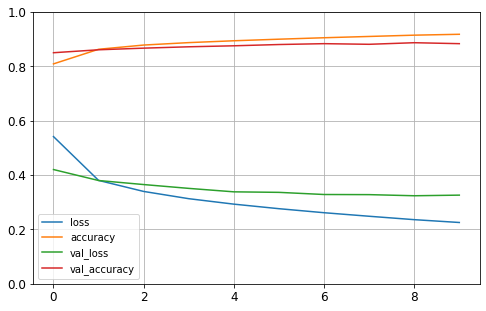

In [117]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

We can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Moreover, the validation curves are close to the training curves, which means that there is not too much overfitting.

In [118]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.8866


[0.3158842921257019, 0.8866000175476074]

The accuracy of the test set of Keras with SGD is 88% which is very good.

In [119]:
y_hat_tf = np.argmax(model.predict(x_test), axis=-1)

In [120]:
print (classification_report(y_test, y_hat_tf))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.82      0.81      1000
           3       0.89      0.92      0.91      1000
           4       0.84      0.85      0.84      1000
           5       0.97      0.93      0.95      1000
           6       0.73      0.66      0.70      1000
           7       0.93      0.93      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.92      0.97      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



We see that the classification report shows that the precision and recall value is very high for class 1, 3, 5, 7, 8, 9 since they are all above 0.89. It is high for class 0, 2, 4 since they are between 0.80 and 0.86. And moderate for class 6 since it is between 0.66 and 0.72. 

<h3>Summary</h3>

| Algorithm          | F1-score | Accuracy |
| ------------------ | -------- | -------  |
| SVM                | 0.91     | 0.91     |
| Random Forest      | 0.88     | 0.88     |  
| Keras (SGD)        | 0.89     | 0.89     |

<h2>Error Analysis</h2>

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# We will use this later

def plot_imgs(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Now let us analyze the types of errors from the SVM model.

In [30]:
y_train_pred = cross_val_predict(svm_clf, x_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5183,    9,   75,  156,    9,    3,  498,    0,   66,    1],
       [   9, 5872,   10,   85,   10,    0,    9,    0,    5,    0],
       [ 109,    5, 5032,   48,  457,    2,  321,    0,   26,    0],
       [ 138,   36,   48, 5459,  186,    0,  114,    0,   19,    0],
       [  15,    6,  414,  176, 5092,    0,  282,    0,   15,    0],
       [   1,    1,    0,    2,    0, 5801,    1,  122,   20,   52],
       [ 745,   15,  481,  138,  350,    1, 4189,    0,   81,    0],
       [   0,    0,    0,    0,    0,   97,    0, 5741,    7,  155],
       [  14,    4,   26,   28,   18,    9,   39,   12, 5848,    2],
       [   0,    0,    1,    1,    0,   52,    0,  178,   23, 5745]],
      dtype=int64)

Note that *cross_val_score* returns score of test fold where *cross_val_predict* returns predicted *y* values for the test fold.

Let us look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

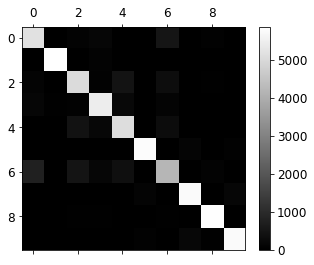

In [36]:
plt.figure(figsize=(5,4))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1, aspect='auto')
plt.colorbar()
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 6s (shirt) look slightly darker than the other digits, which could mean that there are fewer images of 6s in the dataset or that the classifier does not perform as well on 6s as on other digits.

Let’s focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors

In [37]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [38]:
# Check the value of the row_sums
row_sums

array([[6000],
       [6000],
       [6000],
       [6000],
       [6000],
       [6000],
       [6000],
       [6000],
       [6000],
       [6000]], dtype=int64)

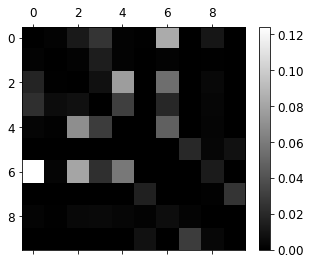

In [42]:
plt.figure(figsize=(5,4))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1, aspect='auto')
plt.colorbar()
plt.show()

Note that rows represent actual classes, while columns represent predicted classes. The column for class 6 is quite bright, which tells you that many images get misclassified as 6s. Moreover,
the row for class 6 is also bright, telling us that actual 6s in general not get properly classified as 6s. As we can see, the confusion matrix is not necessarily symmetrical. We can also see that 2s (pullover) and 4s (coat) often get confused (in both directions).

Analyzing the confusion matrix often gives us insights into ways to improve your classifier. Looking at this plot, it seems that our efforts should be spent on reducing the false 6s. For example, we could try to gather more training data for images that look like 6s (but are not) so that the classifier can learn to distinguish them from real 6s. Or we could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns to stand out more.

Analyzing individual errors can also be a good way to gain insights on what our classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 2s and 4s.

In [43]:
cl_a, cl_b = 2, 4
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

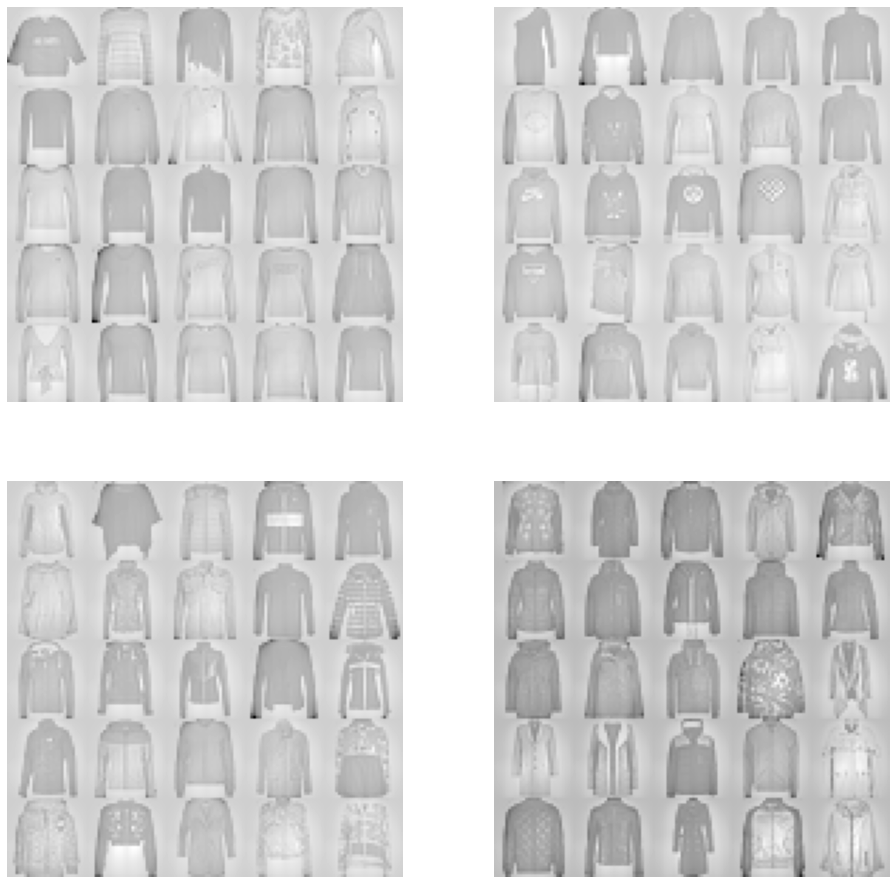

In [44]:
plt.figure(figsize=(16,16))
plt.subplot(221); plot_imgs(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_imgs(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_imgs(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_imgs(x_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 2s, and the two 5 × 5 blocks on the right show images classified as 4s. Some of the images that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are quite confusing that even a human would have trouble classifying them. So one way to reduce the 2/4 confusion would be to preprocess the images to ensure that the distiction between pullover and coat is clear. This will probably help reduce other errors as well.

Similarly, let us plot examples of 0s (t-shirt/top) and 6s (shirt).

In [45]:
cl_a, cl_b = 0, 6
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

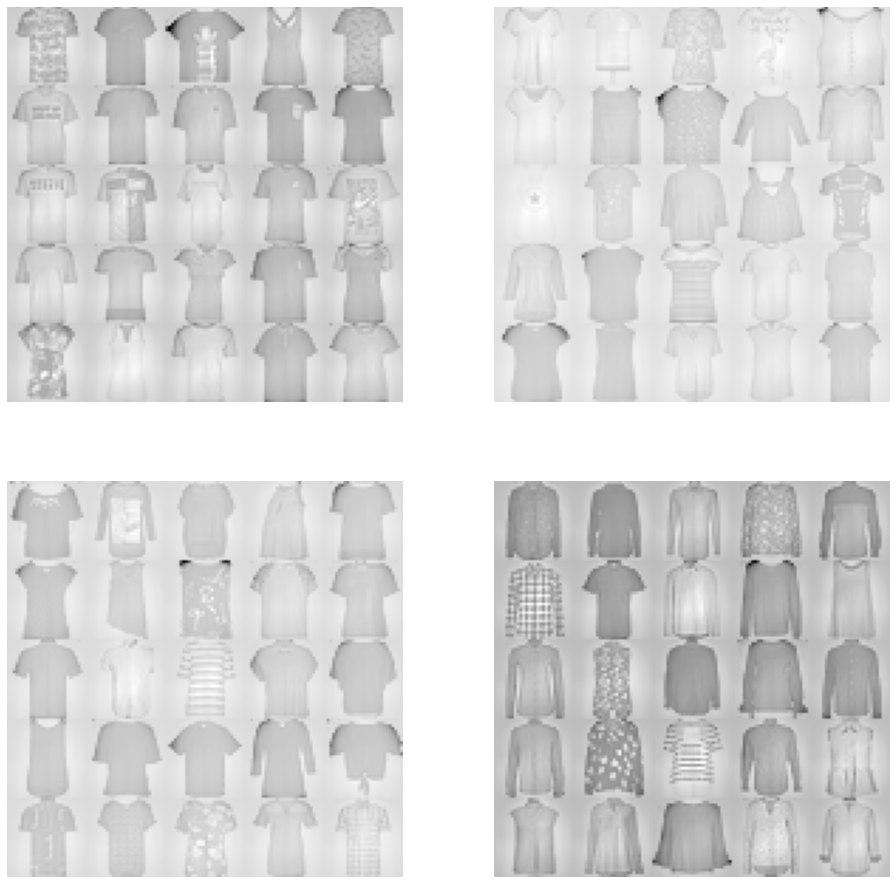

In [46]:
plt.figure(figsize=(16,16))
plt.subplot(221); plot_imgs(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_imgs(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_imgs(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_imgs(x_bb[:25], images_per_row=5)
plt.show()

Again, the two 5 × 5 blocks on the left show digits classified as 0s, and the two 5 × 5 blocks on the right show images classified as 6s. Some of the images that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are quite confusing for the humans eyes also. So probably these need to be preprocessed to ensure that the distiction between t-shirt/top and shirt is clear.